# Simulation using Concord

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scanpy as sc
import time
from pathlib import Path
import torch
import concord as ccd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib as mpl

from matplotlib import font_manager, rcParams
custom_rc = {
    'font.family': 'Arial',  # Set the desired font for this plot
}

mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['pdf.fonttype'] = 42

In [3]:
proj_name = "simulation_clustereasy_classification"
save_dir = f"../save/dev_{proj_name}-{time.strftime('%b%d')}/"
save_dir = Path(save_dir)
save_dir.mkdir(parents=True, exist_ok=True)

data_dir = f"../data/{proj_name}/"
data_dir = Path(data_dir)
data_dir.mkdir(parents=True, exist_ok=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
print(device)
seed = 0
ccd.ul.set_seed(seed)

file_suffix = f"{time.strftime('%b%d-%H%M')}"
file_suffix

cpu


'Aug31-1930'

In [4]:
state_key = 'cluster'
batch_key = 'batch'
state_type = 'cluster'
leiden_key='leiden'
batch_type = 'batch_specific_features'
distribution = 'normal'
concord_methods = ['concord_hcl', 'concord_knn']
other_methods = [
    "PCA", "UMAP", "t-SNE", "DiffusionMap", "NMF", 
    "FactorAnalysis", "FastICA", "LDA", "ZIFA", "scVI", "PHATE", 
    "contrastive"
]
run_methods = concord_methods + other_methods
# exclude ["UMAP", "t-SNE"] from run_method, and save as combined_keys
exclude_keys = ["PCA", "UMAP", "t-SNE"]
combined_keys = ['no_noise', 'wt_noise'] + [key for key in run_methods if key not in exclude_keys]

In [5]:
from concord.simulation import (
    SimConfig, ClusterConfig, BatchConfig, Simulation
)

# ──────────────── Inputs ────────────────
seed = 42
n_cells = [100,100,50]
n_genes = [1000,1000,500]
state_dispersion = [4.0, 2.0, 2.0]

# ─────────────── SimConfig ───────────────
sim_cfg = SimConfig(
    n_cells=n_cells,
    n_genes=n_genes,
    seed=seed,
    non_neg=True,
    to_int=True,
)

# ─────────────── ClusterConfig ───────────────
state_cfg = ClusterConfig(
    n_states=3,
    distribution="normal",
    level=5.0,
    min_level=0.0,
    dispersion=state_dispersion,
    program_structure="uniform",
    program_on_time_fraction=0.3,
    global_non_specific_gene_fraction=0.1,
    pairwise_non_specific_gene_fraction=None,
)

# ─────────────── BatchConfig ───────────────
batch_cfg = BatchConfig(
    n_batches=1,
    effect_type="batch_specific_features",
    distribution="normal",
    level=[5.0],              # One value for 1 batch
    dispersion=[3.0],
    feature_frac=0.15,
)

# ─────────────── Simulation ───────────────
sim = Simulation(sim_cfg, state_cfg, batch_cfg)
adata, adata_state = sim.simulate_data()
adata.layers["counts"] = adata.X.copy()


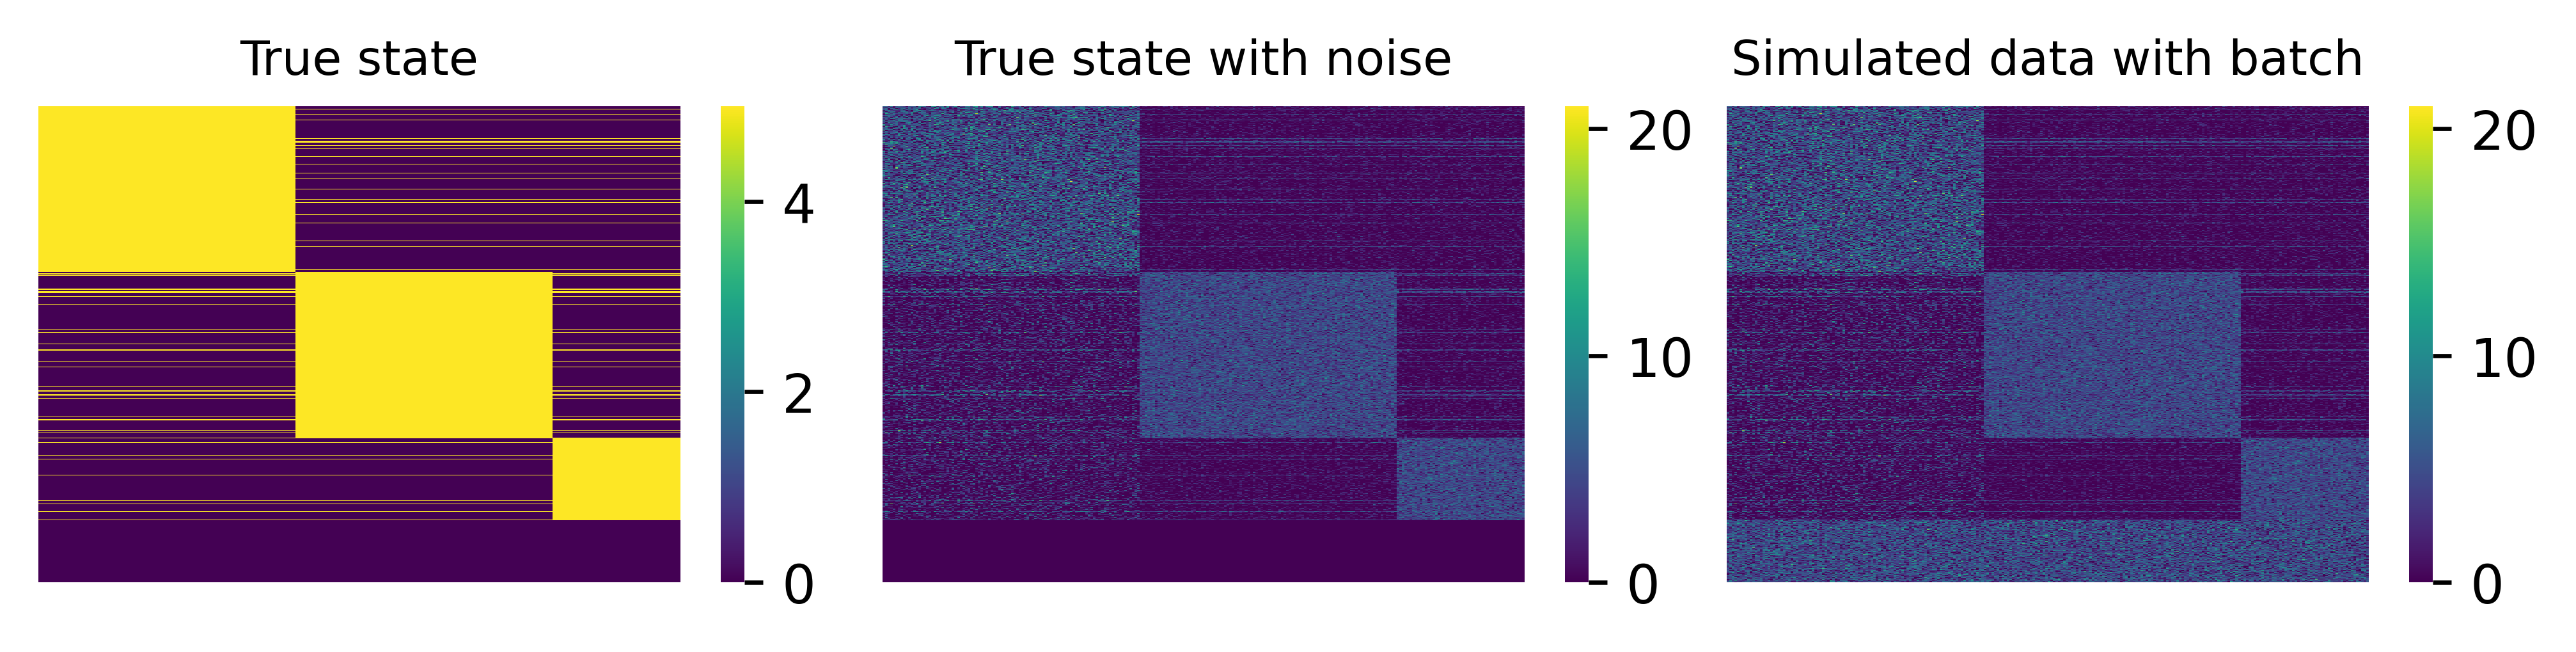

In [6]:
import matplotlib.pyplot as plt
figsize = (2.3, 1.8)
ncols = 3
title_fontsize = 9
dpi = 600
_, _, state_pal = ccd.pl.get_color_mapping(adata, state_key, pal='Paired', seed=seed)
_, _, batch_pal = ccd.pl.get_color_mapping(adata, batch_key, pal='Set1', seed=seed)
pal = {state_key: state_pal, batch_key: batch_pal}
fig, axes = plt.subplots(1, ncols, figsize=(figsize[0] * ncols, figsize[1]), dpi=dpi)
for ax, (val, title) in zip(
        axes,
        [('no_noise', 'True state'),
         ('wt_noise', 'True state with noise'),
         ('X',        'Simulated data with batch')]):

    ccd.pl.heatmap_with_annotations(
        adata,
        val=val,
        obs_keys=[state_key] if val != 'X' else [state_key, batch_key],
        pal=pal,
        use_clustermap=False,        # plain heat‑map
        cluster_rows=False,
        cluster_cols=False,
        yticklabels=False,
        value_annot=False,
        cmap='viridis',
        title=title,
        title_fontsize=9,
        ax=ax,
        show=False                   # don’t flush the figure yet
    )

plt.tight_layout(w_pad=0.0, h_pad=0.1)
plt.savefig(save_dir / f"data_heatmaps_{file_suffix}.svg",
            dpi=600, bbox_inches='tight')
plt.show()

### Run dimension reduction

In [8]:
n_components = 15
adata.obsm['no_noise'] = adata.layers['no_noise']
adata.obsm['wt_noise'] = adata.layers['wt_noise']
ccd.ul.run_pca(adata, source_key='no_noise', result_key='PCA_no_noise', n_pc=n_components, random_state=seed)
sc.pp.neighbors(adata, use_rep='PCA_no_noise', n_neighbors=30, random_state=seed)
ccd.ul.run_umap(adata, source_key='no_noise', result_key='UMAP_no_noise', random_state=seed)
ccd.ul.run_umap(adata, source_key='wt_noise', result_key='UMAP_wt_noise', random_state=seed)

concord - INFO - PCA performed on source data with 15 components
concord - INFO - PCA embedding stored in adata.obsm['PCA_no_noise']


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


concord - INFO - UMAP embedding stored in adata.obsm['UMAP_no_noise']
concord - INFO - UMAP embedding stored in adata.obsm['UMAP_wt_noise']


In [9]:
# Random set 30% class labels to 'unlabeled' for prediction
adata.obs['input_state'] = adata.obs[state_key].astype(str)
adata.obs['input_state'][adata.obs.sample(frac=0.3, random_state=seed).index] = 'unlabeled'
adata.obs['input_state'].value_counts() 
clus_pal = {
    'unlabeled': 'lightgray',
    'cluster_1': 'red',
    'cluster_2': 'blue',
    'cluster_3': 'green',
}
pal = {'input_state': clus_pal,
       state_key: clus_pal,
       'Concord_class_pred': clus_pal
       }


### Train on both

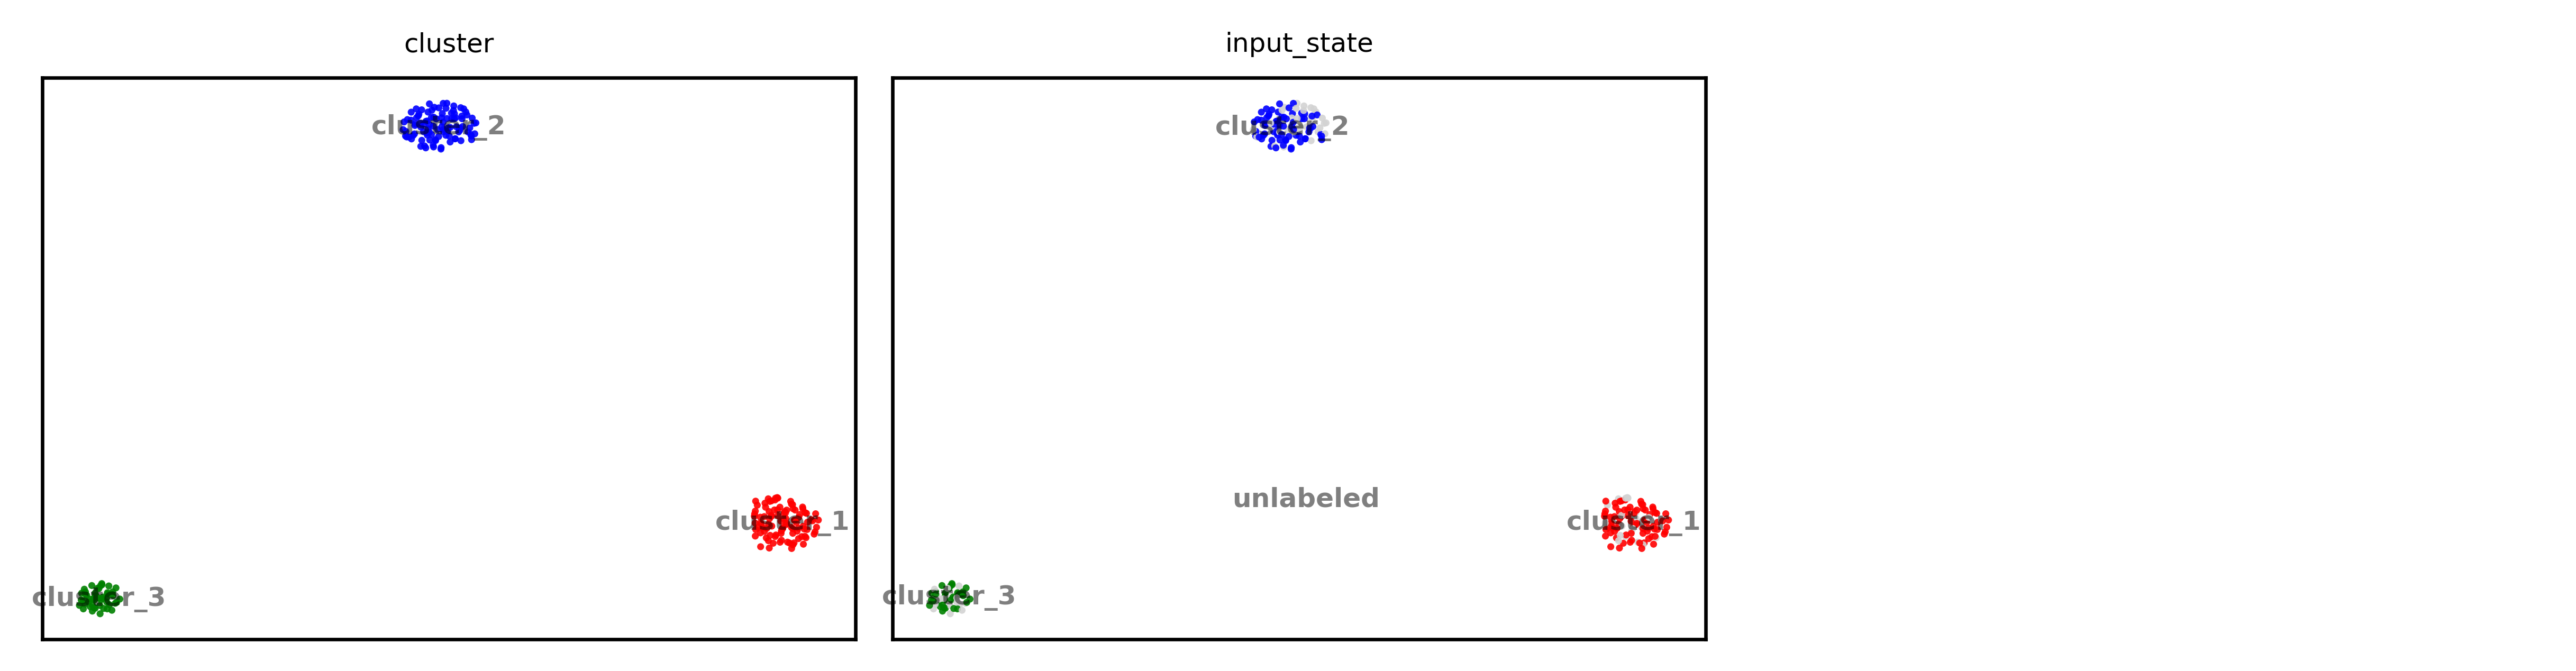

In [12]:
color_by = [state_key, 'input_state'] # Choose which variables you want to visualize
ccd.pl.plot_embedding(
    adata, basis='UMAP_wt_noise', color_by=color_by, figsize=(8, 2), dpi=600, ncols=3, font_size=6, point_size=10, legend_loc='on data',
    pal=pal,
    save_path=save_dir / 'UMAP_wt_noise.png'
)

In [13]:
# If integrating data across batch, simply add the domain_key argument to indicate the batch key in adata.obs
cur_ccd = ccd.Concord(adata=adata, 
                      class_key = 'input_state',
                      use_classifier = True,
                      unlabeled_class = 'unlabeled',
                      clr_beta=1.0,
                      p_intra_knn=0,
                      n_epochs=10,
                      load_data_into_memory=True, 
                      verbose=True,
                      device=device) 

# Encode data, saving the latent embedding in adata.obsm['Concord']
cur_ccd.fit_transform(output_key='Concord')

concord - INFO - Operating directly on the provided AnnData object. Object may be modified.
concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
concord - INFO - Proceeding with all 2875 features in the dataset.
concord - INFO - Using NT-Xent loss with beta=1.0. This will apply hard-negative weighting to the contrastive loss.
concord - INFO - HCL (Contrastive learning with hard negative samples) mode is enabled.


concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
concord - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
concord - INFO - Column 'input_state' is already of type: category
concord - INFO - Unused levels dropped for column 'input_state'.
concord - INFO - Encoder input dim: 2875
concord - INFO - Classifier input dim: 100
concord - INFO - Model loaded to device: cpu
concord - INFO - Total number of parameters: 2988911
concord.model.dataloader - INFO - Using 0 DataLoader workers.
concord.model.anndataset - INFO - Initialized lightweight dataset with 250 samples.
concord.model.dataloader - INFO - Loading all data into memory for fast access. This may consume a lot of RAM. If you run out of memory, please set `load_data_into_memory=False`.
concord - INFO - Augmentation probabilities:
concord - INFO -  - Element mask probability: 0.4
concord - INFO -  - Feature mask probability: 0.3
concord - INFO - 

Epoch 0 Training: 100%|██████████| 1/1 [00:00<00:00, 39.81it/s, loss=7.029]

concord - INFO - Epoch   0 | Train Loss: 7.03, MSE: 0.00, CLASS: 1.38, CONTRAST: 5.65, IMPORTANCE: 0.00
concord - INFO - Epoch:   0 | Train accuracy:  0.34 | precision: 0: 0.37, 1: 0.14, 2: 0.00 | recall: 0: 0.74, 1: 0.05, 2: 0.00 | f1: 0: 0.50, 1: 0.07, 2: 0.00
concord - INFO - Starting epoch 2/10
concord - INFO - Processing chunk 1/1 for epoch 2
concord - INFO - Number of samples in train_dataloader: 250



Epoch 1 Training: 100%|██████████| 1/1 [00:00<00:00, 85.44it/s, loss=7.170]

concord - INFO - Epoch   1 | Train Loss: 7.17, MSE: 0.00, CLASS: 1.62, CONTRAST: 5.55, IMPORTANCE: 0.00
concord - INFO - Epoch:   1 | Train accuracy:  0.53 | precision: 0: 0.00, 1: 0.44, 2: 1.00 | recall: 0: 0.00, 1: 1.00, 2: 0.95 | f1: 0: 0.00, 1: 0.61, 2: 0.97
concord - INFO - Starting epoch 3/10
concord - INFO - Processing chunk 1/1 for epoch 3
concord - INFO - Number of samples in train_dataloader: 250



Epoch 2 Training: 100%|██████████| 1/1 [00:00<00:00, 88.86it/s, loss=5.848]

concord - INFO - Epoch   2 | Train Loss: 5.85, MSE: 0.00, CLASS: 0.32, CONTRAST: 5.53, IMPORTANCE: 0.00
concord - INFO - Epoch:   2 | Train accuracy:  1.00 | precision: 0: 1.00, 1: 1.00, 2: 1.00 | recall: 0: 1.00, 1: 1.00, 2: 1.00 | f1: 0: 1.00, 1: 1.00, 2: 1.00
concord - INFO - Starting epoch 4/10
concord - INFO - Processing chunk 1/1 for epoch 4
concord - INFO - Number of samples in train_dataloader: 250



Epoch 3 Training: 100%|██████████| 1/1 [00:00<00:00, 92.74it/s, loss=5.647]

concord - INFO - Epoch   3 | Train Loss: 5.65, MSE: 0.00, CLASS: 0.17, CONTRAST: 5.48, IMPORTANCE: 0.00
concord - INFO - Epoch:   3 | Train accuracy:  1.00 | precision: 0: 1.00, 1: 1.00, 2: 1.00 | recall: 0: 1.00, 1: 1.00, 2: 1.00 | f1: 0: 1.00, 1: 1.00, 2: 1.00
concord - INFO - Starting epoch 5/10
concord - INFO - Processing chunk 1/1 for epoch 5
concord - INFO - Number of samples in train_dataloader: 250



Epoch 4 Training: 100%|██████████| 1/1 [00:00<00:00, 90.94it/s, loss=5.531]

concord - INFO - Epoch   4 | Train Loss: 5.53, MSE: 0.00, CLASS: 0.05, CONTRAST: 5.48, IMPORTANCE: 0.00
concord - INFO - Epoch:   4 | Train accuracy:  1.00 | precision: 0: 1.00, 1: 1.00, 2: 1.00 | recall: 0: 1.00, 1: 1.00, 2: 1.00 | f1: 0: 1.00, 1: 1.00, 2: 1.00
concord - INFO - Starting epoch 6/10
concord - INFO - Processing chunk 1/1 for epoch 6
concord - INFO - Number of samples in train_dataloader: 250



Epoch 5 Training: 100%|██████████| 1/1 [00:00<00:00, 93.83it/s, loss=5.529]

concord - INFO - Epoch   5 | Train Loss: 5.53, MSE: 0.00, CLASS: 0.02, CONTRAST: 5.51, IMPORTANCE: 0.00
concord - INFO - Epoch:   5 | Train accuracy:  1.00 | precision: 0: 1.00, 1: 1.00, 2: 1.00 | recall: 0: 1.00, 1: 1.00, 2: 1.00 | f1: 0: 1.00, 1: 1.00, 2: 1.00
concord - INFO - Starting epoch 7/10
concord - INFO - Processing chunk 1/1 for epoch 7
concord - INFO - Number of samples in train_dataloader: 250



Epoch 6 Training: 100%|██████████| 1/1 [00:00<00:00, 92.87it/s, loss=5.508]

concord - INFO - Epoch   6 | Train Loss: 5.51, MSE: 0.00, CLASS: 0.01, CONTRAST: 5.50, IMPORTANCE: 0.00
concord - INFO - Epoch:   6 | Train accuracy:  1.00 | precision: 0: 1.00, 1: 1.00, 2: 1.00 | recall: 0: 1.00, 1: 1.00, 2: 1.00 | f1: 0: 1.00, 1: 1.00, 2: 1.00
concord - INFO - Starting epoch 8/10
concord - INFO - Processing chunk 1/1 for epoch 8
concord - INFO - Number of samples in train_dataloader: 250



Epoch 7 Training: 100%|██████████| 1/1 [00:00<00:00, 89.84it/s, loss=5.524]

concord - INFO - Epoch   7 | Train Loss: 5.52, MSE: 0.00, CLASS: 0.01, CONTRAST: 5.52, IMPORTANCE: 0.00
concord - INFO - Epoch:   7 | Train accuracy:  1.00 | precision: 0: 1.00, 1: 1.00, 2: 1.00 | recall: 0: 1.00, 1: 1.00, 2: 1.00 | f1: 0: 1.00, 1: 1.00, 2: 1.00
concord - INFO - Starting epoch 9/10
concord - INFO - Processing chunk 1/1 for epoch 9
concord - INFO - Number of samples in train_dataloader: 250



Epoch 8 Training: 100%|██████████| 1/1 [00:00<00:00, 92.62it/s, loss=5.567]

concord - INFO - Epoch   8 | Train Loss: 5.57, MSE: 0.00, CLASS: 0.01, CONTRAST: 5.56, IMPORTANCE: 0.00
concord - INFO - Epoch:   8 | Train accuracy:  1.00 | precision: 0: 1.00, 1: 1.00, 2: 1.00 | recall: 0: 1.00, 1: 1.00, 2: 1.00 | f1: 0: 1.00, 1: 1.00, 2: 1.00
concord - INFO - Starting epoch 10/10
concord - INFO - Processing chunk 1/1 for epoch 10
concord - INFO - Number of samples in train_dataloader: 250



Epoch 9 Training: 100%|██████████| 1/1 [00:00<00:00, 71.89it/s, loss=5.515]

concord - INFO - Epoch   9 | Train Loss: 5.52, MSE: 0.00, CLASS: 0.00, CONTRAST: 5.51, IMPORTANCE: 0.00
concord - INFO - Epoch:   9 | Train accuracy:  1.00 | precision: 0: 1.00, 1: 1.00, 2: 1.00 | recall: 0: 1.00, 1: 1.00, 2: 1.00 | f1: 0: 1.00, 1: 1.00, 2: 1.00
concord - INFO - Model saved to save/final_model_Aug31-1931.pt
concord - INFO - Final model saved at: save/final_model_Aug31-1931.pt; Configuration saved at: save/config_Aug31-1931.json.
concord.model.dataloader - INFO - Using 0 DataLoader workers.
concord.model.anndataset - INFO - Initialized lightweight dataset with 250 samples.
concord.model.dataloader - INFO - Loading all data into memory for fast access. This may consume a lot of RAM. If you run out of memory, please set `load_data_into_memory=False`.
concord - INFO - Predicting for chunk 1/1


concord - INFO - Predictions added to AnnData object with base key 'Concord'.


concord - INFO - UMAP embedding stored in adata.obsm['Concord_UMAP']


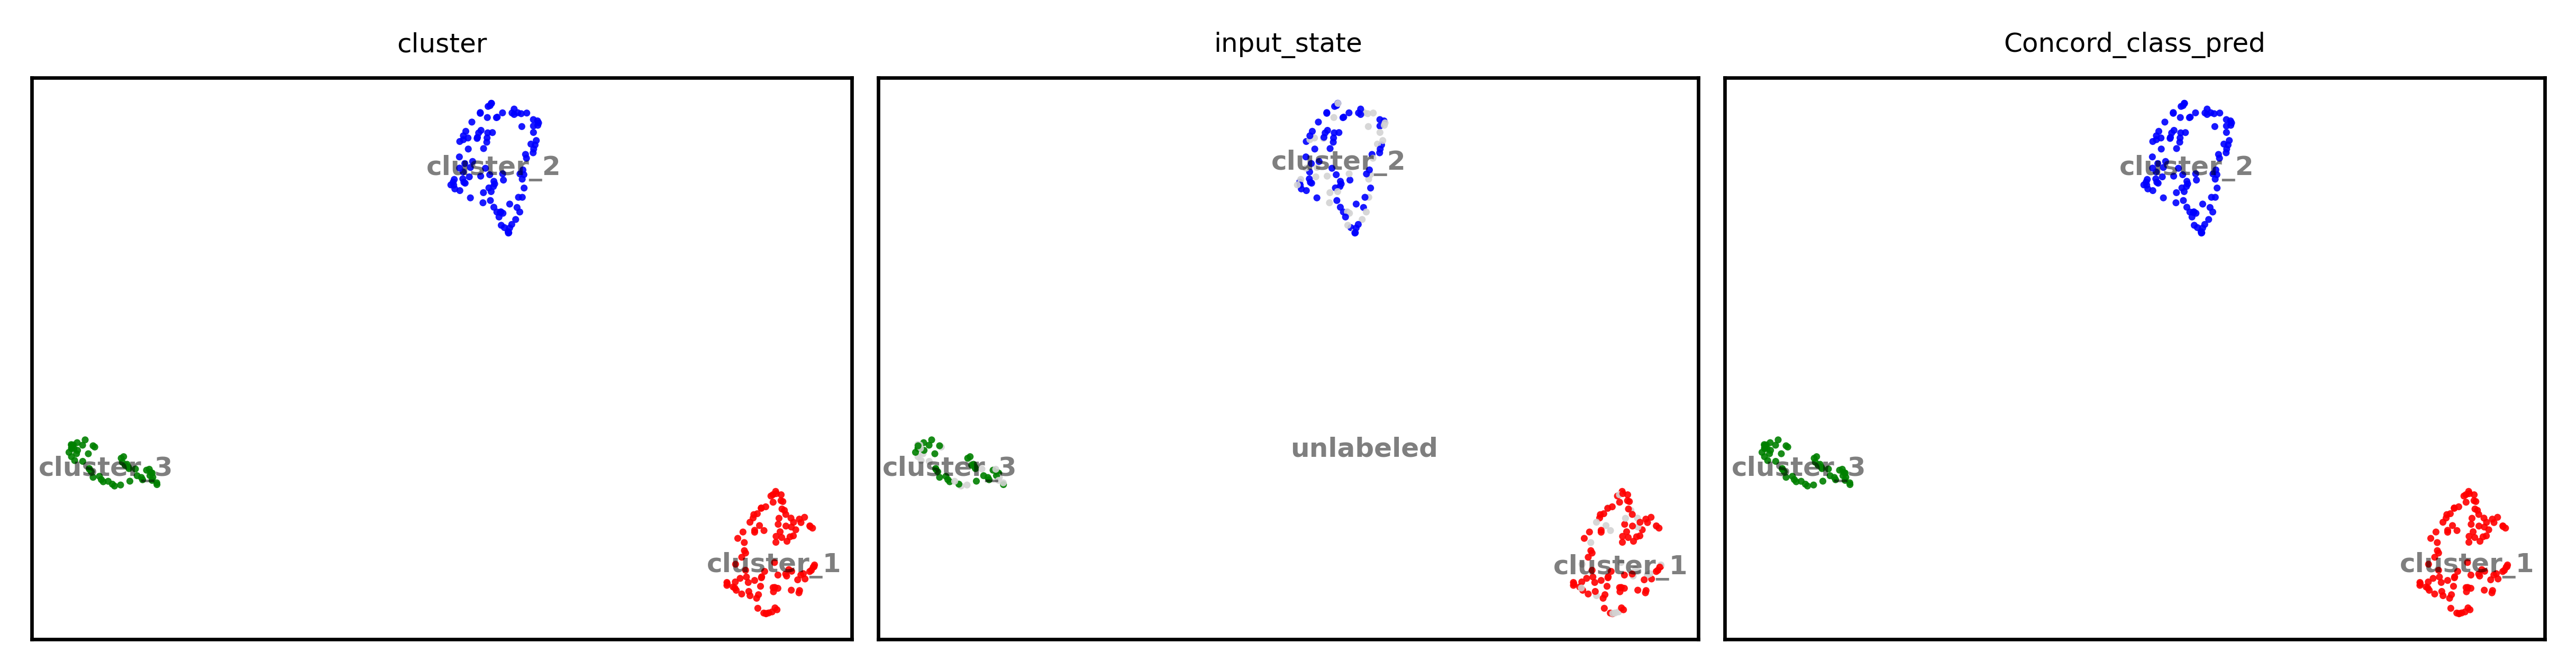

In [15]:
ccd.ul.run_umap(adata, source_key='Concord', result_key='Concord_UMAP', n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean')
color_by = [state_key, 'input_state', 'Concord_class_pred']
ccd.pl.plot_embedding(
    adata, basis='Concord_UMAP', color_by=color_by, figsize=(8, 2), dpi=600, ncols=3, font_size=6, point_size=10, legend_loc='on data',
    pal=pal,
    save_path=save_dir / 'Concord_UMAP.png'
)

### Train only on labeled and predict on unlabeled

In [16]:
adata_train = adata[adata.obs['input_state'] != 'unlabeled']
adata_pred = adata[adata.obs['input_state'] == 'unlabeled']

In [17]:
cur_ccd = ccd.Concord(adata=adata_train, 
                      class_key = 'input_state',
                      use_classifier = True,
                      clr_beta=1.0,
                      p_intra_knn=0,
                      n_epochs=10,
                      load_data_into_memory=True, 
                      verbose=True,
                      save_dir=save_dir / 'model/', # directory to save model checkpoints
                      ) 
# Encode data, saving the latent embedding in adata.obsm['Concord']
cur_ccd.fit_transform(output_key='Concord')

concord - INFO - Operating directly on the provided AnnData object. Object may be modified.


concord - WARNING - Input data in adata.X appears to be raw counts. CONCORD performs best on normalized and log-transformed data. Consider setting normalize_total=True and log1p=True.
concord - WARNING - No input feature list provided. It is recommended to first select features using the command `concord.ul.select_features()`.
concord - INFO - Proceeding with all 2875 features in the dataset.
concord - INFO - Using NT-Xent loss with beta=1.0. This will apply hard-negative weighting to the contrastive loss.
concord - INFO - HCL (Contrastive learning with hard negative samples) mode is enabled.
concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
concord - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
concord - INFO - Column 'input_state' is already of type: category
concord - INFO - Unused levels dropped for column 'input_state'.
concord - INFO - Encoder input dim: 2875
concord - INFO - Classifier 

Epoch 0 Training: 100%|██████████| 1/1 [00:00<00:00, 52.30it/s, loss=6.744]

concord - INFO - Epoch   0 | Train Loss: 6.74, MSE: 0.00, CLASS: 1.25, CONTRAST: 5.50, IMPORTANCE: 0.00
concord - INFO - Epoch:   0 | Train accuracy:  0.36 | precision: 0: 0.38, 1: 0.11, 2: 0.67 | recall: 0: 0.73, 1: 0.04, 2: 0.14 | f1: 0: 0.50, 1: 0.06, 2: 0.24
concord - INFO - Starting epoch 2/10
concord - INFO - Processing chunk 1/1 for epoch 2
concord - INFO - Number of samples in train_dataloader: 175



Epoch 1 Training: 100%|██████████| 1/1 [00:00<00:00, 86.31it/s, loss=6.252]

concord - INFO - Epoch   1 | Train Loss: 6.25, MSE: 0.00, CLASS: 0.84, CONTRAST: 5.41, IMPORTANCE: 0.00
concord - INFO - Epoch:   1 | Train accuracy:  0.41 | precision: 0: 0.00, 1: 0.41, 2: 0.00 | recall: 0: 0.00, 1: 1.00, 2: 0.00 | f1: 0: 0.00, 1: 0.58, 2: 0.00
concord - INFO - Starting epoch 3/10
concord - INFO - Processing chunk 1/1 for epoch 3
concord - INFO - Number of samples in train_dataloader: 175



Epoch 2 Training: 100%|██████████| 1/1 [00:00<00:00, 96.63it/s, loss=5.964]

concord - INFO - Epoch   2 | Train Loss: 5.96, MSE: 0.00, CLASS: 0.62, CONTRAST: 5.34, IMPORTANCE: 0.00
concord - INFO - Epoch:   2 | Train accuracy:  0.63 | precision: 0: 0.55, 1: 0.00, 2: 1.00 | recall: 0: 1.00, 1: 0.00, 2: 1.00 | f1: 0: 0.71, 1: 0.00, 2: 1.00
concord - INFO - Starting epoch 4/10
concord - INFO - Processing chunk 1/1 for epoch 4
concord - INFO - Number of samples in train_dataloader: 175



Epoch 3 Training: 100%|██████████| 1/1 [00:00<00:00, 99.70it/s, loss=5.330]

concord - INFO - Epoch   3 | Train Loss: 5.33, MSE: 0.00, CLASS: 0.05, CONTRAST: 5.28, IMPORTANCE: 0.00
concord - INFO - Epoch:   3 | Train accuracy:  1.00 | precision: 0: 1.00, 1: 1.00, 2: 1.00 | recall: 0: 1.00, 1: 1.00, 2: 1.00 | f1: 0: 1.00, 1: 1.00, 2: 1.00
concord - INFO - Starting epoch 5/10
concord - INFO - Processing chunk 1/1 for epoch 5
concord - INFO - Number of samples in train_dataloader: 175



Epoch 4 Training: 100%|██████████| 1/1 [00:00<00:00, 90.84it/s, loss=5.365]

concord - INFO - Epoch   4 | Train Loss: 5.36, MSE: 0.00, CLASS: 0.02, CONTRAST: 5.35, IMPORTANCE: 0.00
concord - INFO - Epoch:   4 | Train accuracy:  1.00 | precision: 0: 1.00, 1: 1.00, 2: 1.00 | recall: 0: 1.00, 1: 1.00, 2: 1.00 | f1: 0: 1.00, 1: 1.00, 2: 1.00
concord - INFO - Starting epoch 6/10
concord - INFO - Processing chunk 1/1 for epoch 6
concord - INFO - Number of samples in train_dataloader: 175



Epoch 5 Training: 100%|██████████| 1/1 [00:00<00:00, 58.30it/s, loss=5.393]

concord - INFO - Epoch   5 | Train Loss: 5.39, MSE: 0.00, CLASS: 0.02, CONTRAST: 5.38, IMPORTANCE: 0.00
concord - INFO - Epoch:   5 | Train accuracy:  1.00 | precision: 0: 1.00, 1: 1.00, 2: 1.00 | recall: 0: 1.00, 1: 1.00, 2: 1.00 | f1: 0: 1.00, 1: 1.00, 2: 1.00
concord - INFO - Starting epoch 7/10
concord - INFO - Processing chunk 1/1 for epoch 7
concord - INFO - Number of samples in train_dataloader: 175



Epoch 6 Training: 100%|██████████| 1/1 [00:00<00:00, 93.57it/s, loss=5.333]

concord - INFO - Epoch   6 | Train Loss: 5.33, MSE: 0.00, CLASS: 0.02, CONTRAST: 5.32, IMPORTANCE: 0.00
concord - INFO - Epoch:   6 | Train accuracy:  1.00 | precision: 0: 1.00, 1: 1.00, 2: 1.00 | recall: 0: 1.00, 1: 1.00, 2: 1.00 | f1: 0: 1.00, 1: 1.00, 2: 1.00
concord - INFO - Starting epoch 8/10
concord - INFO - Processing chunk 1/1 for epoch 8
concord - INFO - Number of samples in train_dataloader: 175



Epoch 7 Training: 100%|██████████| 1/1 [00:00<00:00, 102.05it/s, loss=5.345]

concord - INFO - Epoch   7 | Train Loss: 5.34, MSE: 0.00, CLASS: 0.01, CONTRAST: 5.33, IMPORTANCE: 0.00
concord - INFO - Epoch:   7 | Train accuracy:  1.00 | precision: 0: 1.00, 1: 1.00, 2: 1.00 | recall: 0: 1.00, 1: 1.00, 2: 1.00 | f1: 0: 1.00, 1: 1.00, 2: 1.00
concord - INFO - Starting epoch 9/10
concord - INFO - Processing chunk 1/1 for epoch 9
concord - INFO - Number of samples in train_dataloader: 175



Epoch 8 Training: 100%|██████████| 1/1 [00:00<00:00, 104.08it/s, loss=5.249]

concord - INFO - Epoch   8 | Train Loss: 5.25, MSE: 0.00, CLASS: 0.01, CONTRAST: 5.24, IMPORTANCE: 0.00
concord - INFO - Epoch:   8 | Train accuracy:  1.00 | precision: 0: 1.00, 1: 1.00, 2: 1.00 | recall: 0: 1.00, 1: 1.00, 2: 1.00 | f1: 0: 1.00, 1: 1.00, 2: 1.00
concord - INFO - Starting epoch 10/10
concord - INFO - Processing chunk 1/1 for epoch 10
concord - INFO - Number of samples in train_dataloader: 175



Epoch 9 Training: 100%|██████████| 1/1 [00:00<00:00, 112.10it/s, loss=5.329]

concord - INFO - Epoch   9 | Train Loss: 5.33, MSE: 0.00, CLASS: 0.01, CONTRAST: 5.32, IMPORTANCE: 0.00
concord - INFO - Epoch:   9 | Train accuracy:  1.00 | precision: 0: 1.00, 1: 1.00, 2: 1.00 | recall: 0: 1.00, 1: 1.00, 2: 1.00 | f1: 0: 1.00, 1: 1.00, 2: 1.00
concord - INFO - Model saved to ../save/dev_simulation_clustereasy_classification-Aug31/model/final_model_Aug31-1931.pt
concord - INFO - Final model saved at: ../save/dev_simulation_clustereasy_classification-Aug31/model/final_model_Aug31-1931.pt; Configuration saved at: ../save/dev_simulation_clustereasy_classification-Aug31/model/config_Aug31-1931.json.
concord.model.dataloader - INFO - Using 0 DataLoader workers.
concord.model.anndataset - INFO - Initialized lightweight dataset with 175 samples.
concord.model.dataloader - INFO - Loading all data into memory for fast access. This may consume a lot of RAM. If you run out of memory, please set `load_data_into_memory=False`.
concord - INFO - Predicting for chunk 1/1
concord - IN

concord - INFO - UMAP embedding stored in adata.obsm['Concord_UMAP']


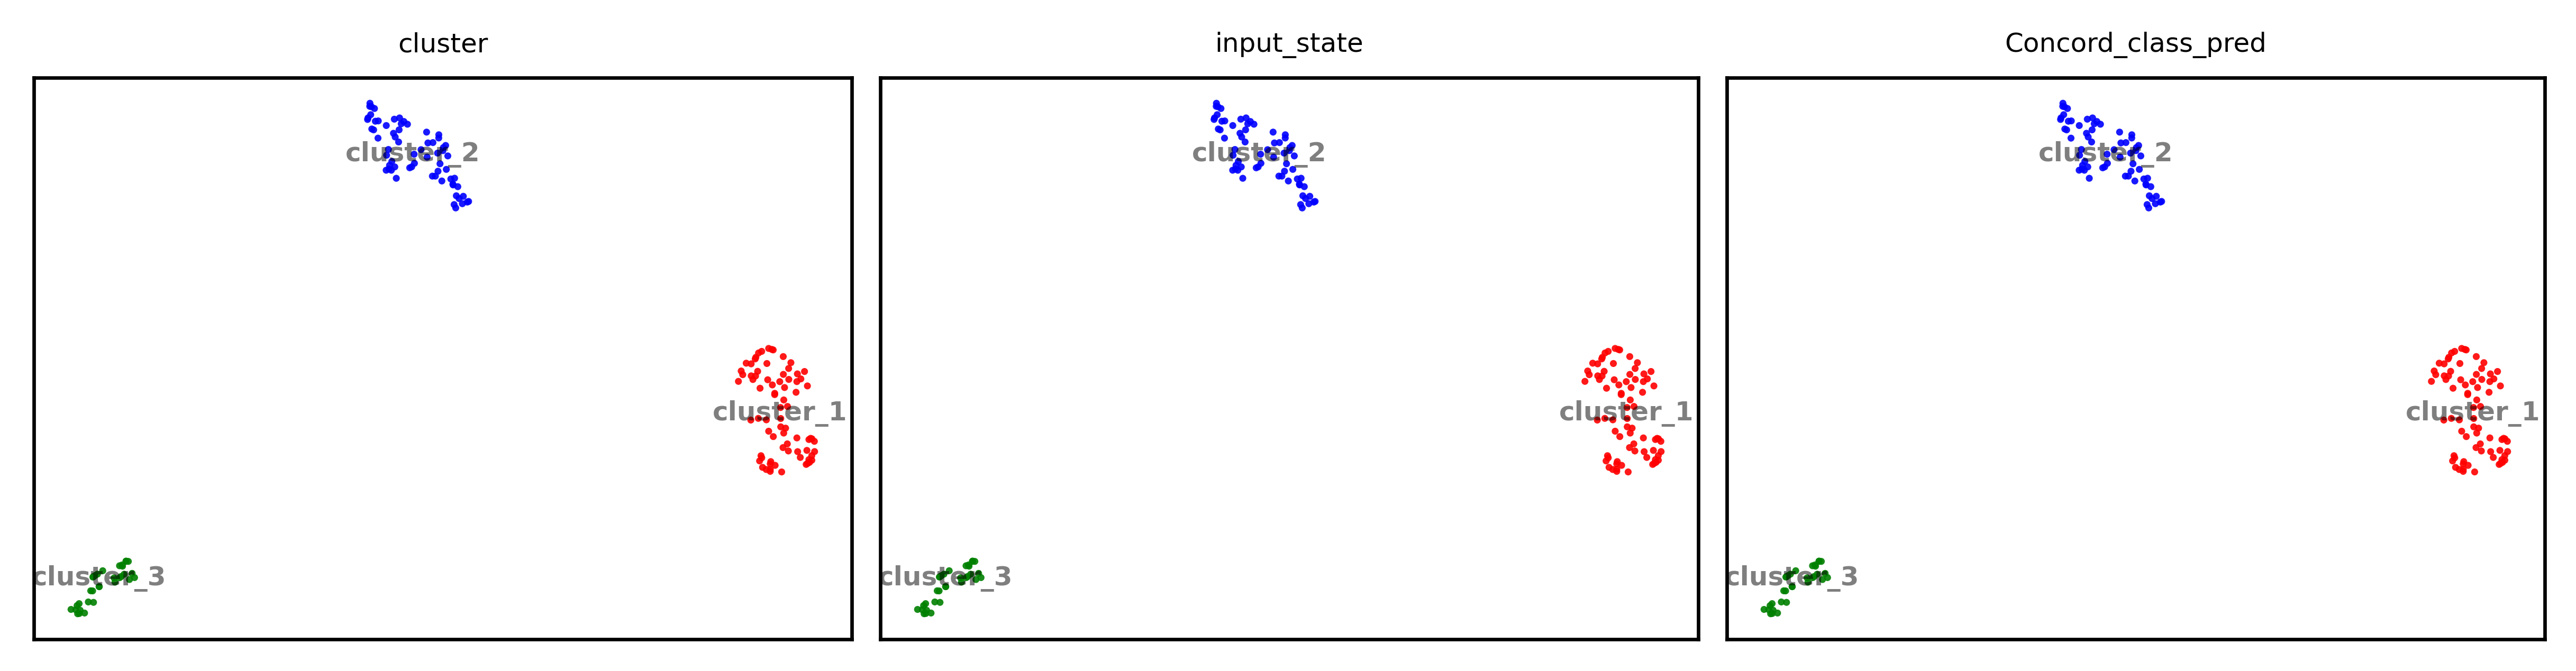

In [20]:
ccd.ul.run_umap(adata_train, source_key='Concord', result_key='Concord_UMAP', n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean')

ccd.pl.plot_embedding(
    adata_train, basis='Concord_UMAP', color_by=color_by, figsize=(8, 2), dpi=600, ncols=3, font_size=6, point_size=10, legend_loc='on data',
    pal=pal,
    save_path=save_dir / 'Concord_UMAP.png'
)

In [ ]:
#cur_ccd = ccd.Concord.load(model_dir=save_dir / 'model/',)
cur_ccd.predict_adata(adata_pred, output_key='Concord')

concord - INFO - Loading configuration from: ../save/dev_simulation_clustereasy_classification-Aug31/model/config_Aug31-1931.json
concord - INFO - Loading model weights from: ../save/dev_simulation_clustereasy_classification-Aug31/model/final_model_Aug31-1931.pt
concord - INFO - Encoder input dim: 2875
concord - INFO - Classifier input dim: 100
concord - INFO - Model loaded to device: cpu
concord - INFO - Total number of parameters: 2988911
concord - INFO - Loading pre-trained model from ../save/dev_simulation_clustereasy_classification-Aug31/model/final_model_Aug31-1931.pt
concord - INFO - Pre-trained Concord model loaded successfully.
concord - WARNING - domain/batch information not found, all samples will be treated as from single domain/batch.
concord - WARNING - Only one domain found in the data. Setting p_intra_domain to 1.0.
concord.model.dataloader - INFO - Using 0 DataLoader workers.
concord.model.anndataset - INFO - Initialized lightweight dataset with 75 samples.
concord.mod

concord - INFO - UMAP embedding stored in adata.obsm['Concord_UMAP_2D']


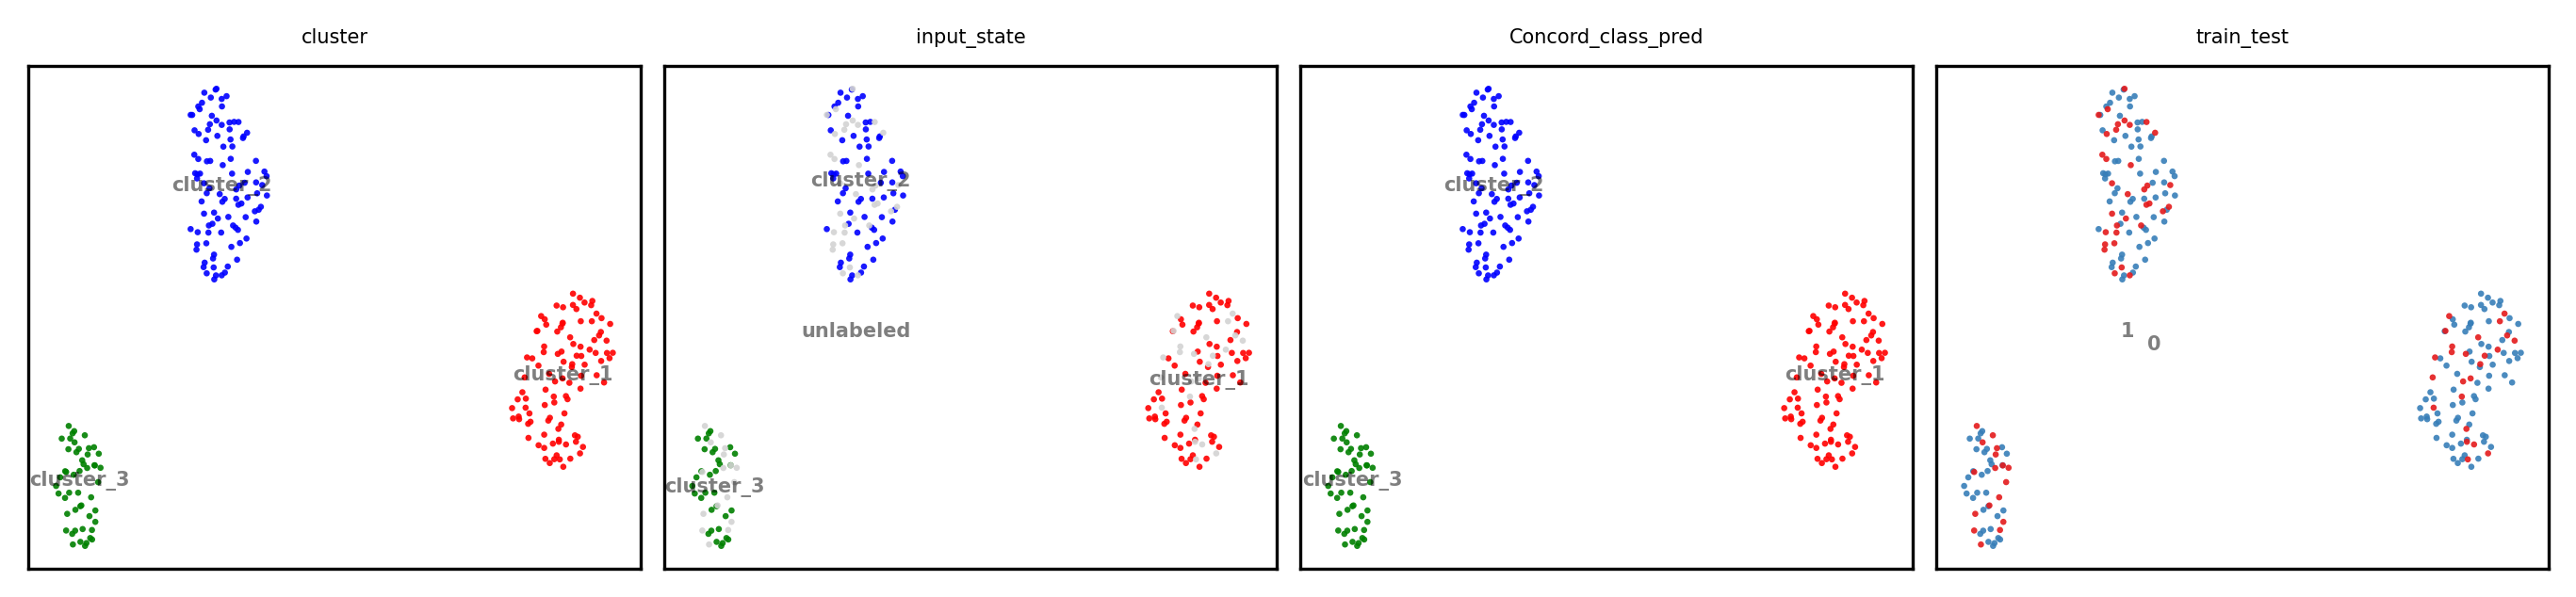

In [ ]:
adata_merge = adata_train.concatenate(adata_pred, batch_key='train_test', index_unique=None)
ccd.ul.run_umap(adata_merge, source_key='Concord', result_key='Concord_UMAP_2D', n_components=2, n_neighbors=30, min_dist=0.5, metric='euclidean', random_state=seed)

color_by = [state_key, 'input_state', 'Concord_class_pred', 'train_test']
show_basis = 'Concord_UMAP_2D'   
ccd.pl.plot_embedding(
    adata_merge, show_basis, color_by, figsize=(9,2), dpi=300, ncols=4, font_size=5, point_size=10, legend_loc='on data',
    pal=pal,
    save_path=save_dir / f"{show_basis}_{file_suffix}.png"
)
